## Portfolio/Risk Management
- Summary
- Drawdown Break Strategy
- Crypto Portfolio DDB
- Drawdown Break Portfolio

In [1]:
# Import libraries 
from matplotlib import cycler
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import ta 

import yfinance as yf

In [2]:
facecolor_theme = '#1f1f1f'

colors = cycler('color', 
                ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor = facecolor_theme)
plt.rc('axes', facecolor = facecolor_theme, edgecolor = 'white',
       axisbelow = True, grid = True, prop_cycle = colors,
       labelcolor = 'white')
plt.rc('xtick', color = 'white')
plt.rc('ytick', direction = 'out', color = 'white')
plt.rc('legend', facecolor = facecolor_theme, edgecolor = facecolor_theme)
plt.rc('text', color = 'white')
plt.rc('figure', facecolor = facecolor_theme)

# Set grid lines to be thin
plt.rc('grid', linewidth=0.1, color='white')

import warnings
warnings.filterwarnings('ignore')

In [3]:
def BackTest(serie, annualiazed_scalar=252):
  global serie_print

  # FUNCTION TO BUT THE RIGHT DATE FORMAT
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df

  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  try:
    # Concat the returns and the sp500
    val = pd.concat((serie, sp500), axis=1).dropna()

  except:
    # Put the right date format
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concat the returns and the sp500
    val = pd.concat((serie, sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

In [4]:
def breakout(asset, cost=0.001, duration=7, dd_break=None):
    
    def drawdown_function(serie):
        # We compute Cumsum of the returns
        cum = serie.dropna().cumsum() + 1

        # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
        running_max = np.maximum.accumulate(cum)

        # We compute drawdown
        drawdown = cum/running_max - 1
    
        return drawdown
    
    def preprocessing(asset):
        
        # Import data 
        df = yf.download(asset).dropna()
    
        # Rename columns 
        df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
        df.index.name = 'time'
    
        # Remove adj close 
        df = df.drop('adj close', axis=1)
    
        return df

    df = preprocessing(asset)
    df["resistance"] = df["close"].rolling(30).max().shift(3)
    df["support"] = df["close"].rolling(30).min().shift(3)

    distance = 0.5 / 100

    # Shift the values
    df["Close Yesterday"] = df["close"].shift(1)
    df["Resistance Yesterday"] = df["resistance"].shift(1)
    df["signal_long"] = np.nan

    df.loc[(df["close"] > df["resistance"]*(1+distance)) &\
             (df["Close Yesterday"] < df["Resistance Yesterday"]), "signal_long"] = 1

    df["signal_long"] = df["signal_long"].fillna(value=0)

    # Compute the percentage of variation of the asset
    df["pct"] = df["close"].pct_change(1)

    # Compute the return of the strategy

    df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal_long"].shift(duration))

    df.loc[df["signal_long"] == 1,"return"] = df["return"] - cost

    if dd_break != None:
        df["drawdown"] = drawdown_function(df["return"])
        df.loc[df["drawdown"].shift(1) < -dd_break, "return"] = 0

    return df["return"]

# Drawdown break Strategy

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


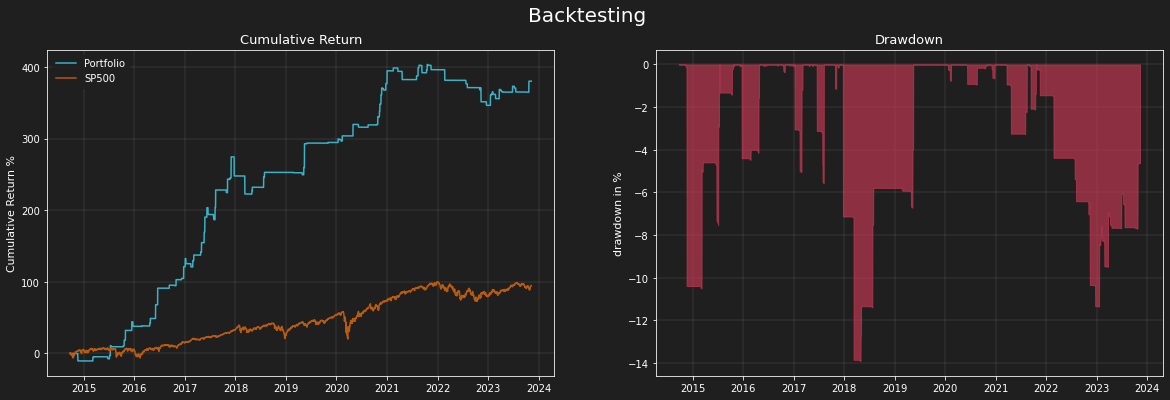

Sortino: 0.2
Beta: 0.001
Alpha: 5.922 %
MaxDrawdown: 13.902 %
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


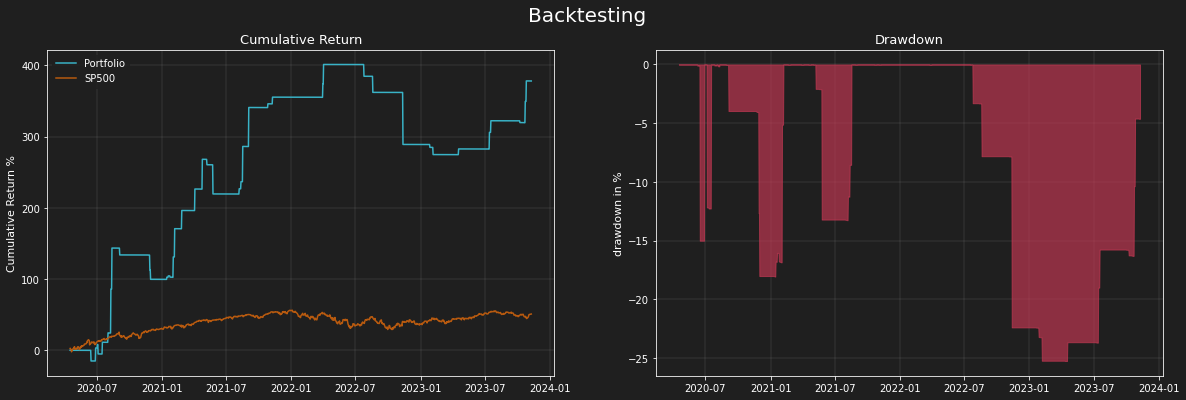

Sortino: 0.168
Beta: -0.037
Alpha: 15.661 %
MaxDrawdown: 25.259 %
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


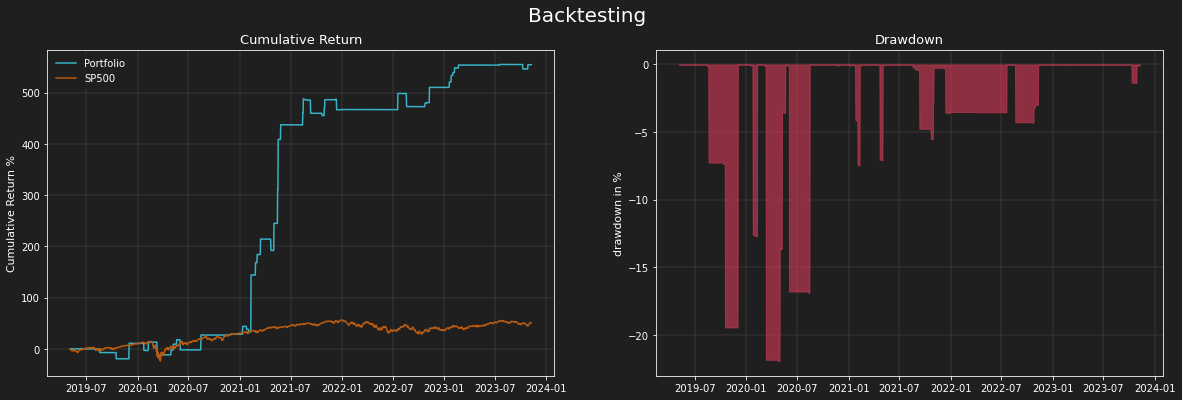

Sortino: 0.347
Beta: 0.1
Alpha: 15.725 %
MaxDrawdown: 21.937 %
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


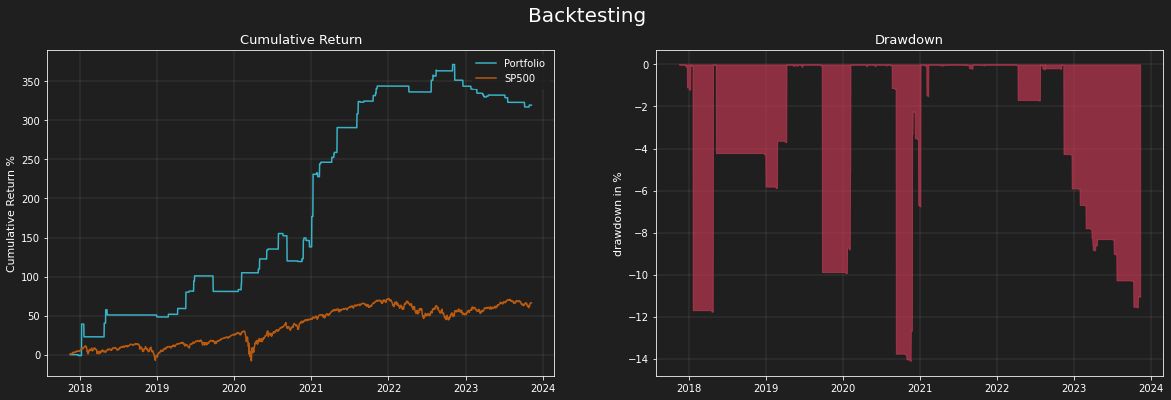

Sortino: 0.217
Beta: 0.061
Alpha: 7.142 %
MaxDrawdown: 14.113 %
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


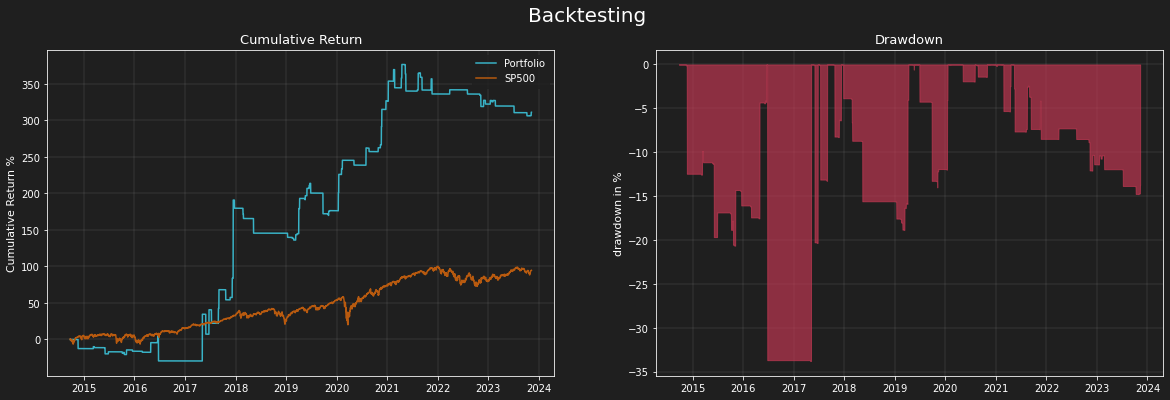

Sortino: 0.098
Beta: 0.027
Alpha: 4.723 %
MaxDrawdown: 33.775 %


In [5]:
# DDB to 15% but we need to take the SL into account
namelist = ["BTC", "SOL", "MATIC", "ETH", "LTC"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
    ret = breakout(f"{name}-USD", duration=7, dd_break=0.15)
    returns = pd.concat((returns,ret), axis=1)
    BackTest(ret, 52)

# Crypto strategies portfolio

In [6]:
def breakout(asset, cost=0.001, duration=7, dd_break=None):
  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    
    return drawdown
    
  def preprocessing(asset):
        
        # Import data 
        df = yf.download(asset).dropna()
    
        # Rename columns 
        df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
        df.index.name = 'time'
    
        # Remove adj close 
        df = df.drop('adj close', axis=1)
    
        return df

  df = preprocessing(asset)
  df["resistance"] = df["close"].rolling(30).max().shift(3)
  df["support"] = df["close"].rolling(30).min().shift(3)

  distance = 0.5/100

  # Shift the values
  df["Close Yesterday"] = df["close"].shift(1)
  df["Resistance Yesterday"] = df["resistance"].shift(1)
  df["signal_long"] = np.nan

  df.loc[(df["close"] > df["resistance"]*(1+distance)) &\
         (df["Close Yesterday"] < df["Resistance Yesterday"]), "signal_long"] = 1

  df["signal_long"] = df["signal_long"].fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy
  df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal_long"].shift(duration))
  
  df.loc[df["signal_long"] == 1, "return"] = df["return"] - cost

  if dd_break!=None:
    df["drawdown"] = drawdown_function(df["return"])
    df.loc[df["drawdown"].shift(1)<-dd_break, "return"] = 0

  return df["return"]

In [7]:
def drawdown_function(serie):
   # We compute Cumsum of the returns
   cum = serie.dropna().cumsum() + 1

   # We compute max of the cumsum on the period (accumulate max)
   running_max = np.maximum.accumulate(cum)

   # We compute drawdown
   drawdown = cum/running_max - 1
    
   return drawdown

In [10]:
# DDB to 15% but we need to take the SL into account
namelist = ["BTC", "SOL", "MATIC", "ETC", "ETH", "LTC"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}-USD", duration=7)
  returns = pd.concat((returns, ret), axis=1)

# Create empty DataFrame
returns_ = pd.DataFrame()

# Number of asset in the portfolio
returns_["count"] = returns.shape[1] - returns.isna().sum(axis=1)

# Portfolio creation
returns_["return"] = returns.sum(axis=1) / returns_["count"]

# Drawdown computation
returns_["drawdown"] = drawdown_function(returns_["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
returns_.loc[returns_["drawdown"].shift(1) < -0.1, "return"] = 0

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


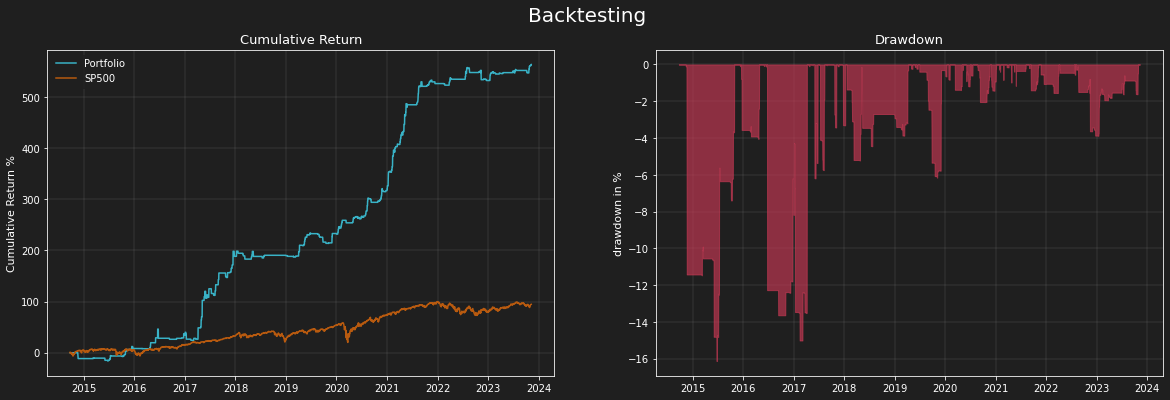

Sortino: 0.622
Beta: 0.021
Alpha: 8.612 %
MaxDrawdown: 16.124 %


In [11]:
BackTest(returns_["return"], 52)